In [1]:
import numpy as np
import pickle
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('/Users/vsriniv/Documents/Research/Github/PatchSim')
import patchsim as sim
import hyperopt
import seaborn as sns
from hyperopt import hp, Trials
from tqdm import tqdm

In [2]:
gt = pd.read_csv('../data/Ebola_Updated_Feb18.csv',delimiter='\t',dtype={'date':str})
gt['Date'] = gt.date.apply(lambda x: datetime.strptime(x,'%Y%m%d'))
gt = gt[gt.Date>=datetime.strptime('20180805','%Y%m%d')] ## Starting on August 5th, the first non-NaN value
gt['Ob_Day'] = gt.Date.apply(lambda x : (x - datetime.strptime('20180805','%Y%m%d')).days)
#gt['Ob_Week'] = gt.Ob_Day.apply(lambda x: x//7)

# Get top 6 healthzones
key_hzs = gt[gt.Date==gt.Date.max()][['health_zone','total_c']].sort_values('total_c',ascending=False).head(7)['health_zone'].values
key_hzs = sorted(list(set(key_hzs) - {'all'}))

T = len(gt[gt.health_zone=='all'])

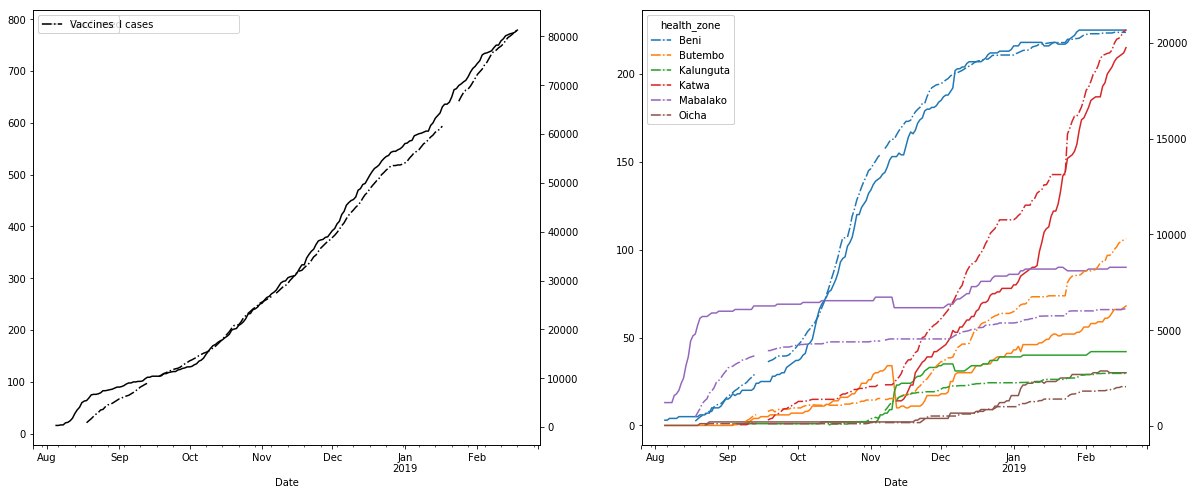

In [3]:
f, axarr = plt.subplots(1,2, figsize=(20,8))
gt[gt.health_zone=='all'].plot(x='Date',y='total_c',ax=axarr[0],color='k',label='Confirmed cases                          ')
ax0 = axarr[0].twinx()
gt[gt.health_zone=='all'].plot(x='Date',y='total_vacc',ax=ax0, color='k', label='Vaccines', ls='-.')

gt[gt.health_zone.isin(key_hzs)].pivot(index='Date',columns='health_zone',values='total_c').plot(ax=axarr[1])
ax1 = axarr[1].twinx()
gt[gt.health_zone.isin(key_hzs)].pivot(index='Date',columns='health_zone',values='total_vacc').plot(ax=ax1, ls='-.')
    
# gt_start = datetime.strptime('20180805','%Y%m%d')
# gt_end = datetime.strptime('20190218','%Y%m%d')
# axarr[0].set_xlim([gt_start,gt_end])
# axarr[1].set_xlim([gt_start,gt_end])

### Use below snippet if you need weekly ground truth (and plots)

### Analyzing vax_to_cases ratio

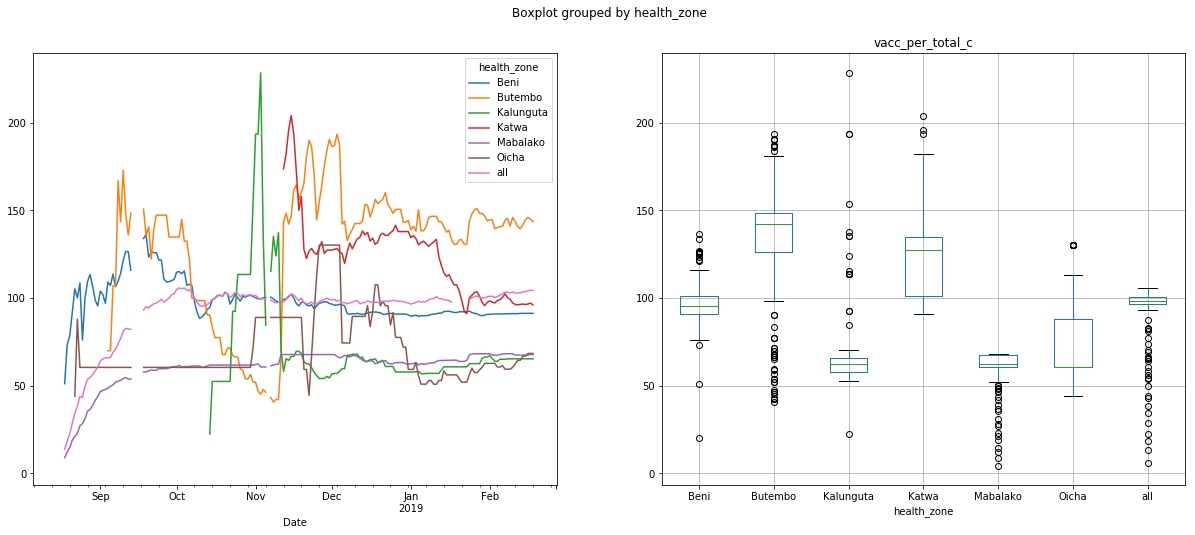

In [4]:
with np.errstate(divide='ignore'):
    gt['vacc_per_total_c'] = np.divide(gt.total_vacc.values,gt.total_c.values)
f,axarr = plt.subplots(1,2,figsize=(20,8))
gt[gt.health_zone.isin(key_hzs+['all'])].pivot(index='Date',columns='health_zone',values='vacc_per_total_c').plot(ax=axarr[0])
gt[gt.health_zone.isin(key_hzs+['all'])].boxplot(column='vacc_per_total_c',by='health_zone',ax=axarr[1])

### Preparing network file (Parameters: non-commute)

In [5]:
df = pd.read_csv('../data/pop_travel/OD_Matrix_v3_cleaned.csv')
df = df[['Origin','Origin_Pop']].drop_duplicates()
df.Origin = df.Origin.str.replace(' ','_')
df.to_csv('../data/patchsim/pop_drc_v3.csv',sep=' ',index=None,header=None)

def prep_network_file(non_commute):
    od_matrix = pd.read_csv('../data/pop_travel/OD_Matrix_v3_cleaned.csv')
    od_matrix['Grav'] = (od_matrix.Origin_Pop*od_matrix.Destination_Pop)/(od_matrix.Travel_Time**2)
    od_matrix = od_matrix.assign(norm_flow=od_matrix.Grav.div(od_matrix.groupby(['Origin']).Grav.transform('sum')))
    od_matrix = od_matrix[['Origin','Destination','norm_flow']]
    hz = od_matrix.Origin.unique()
    df = pd.DataFrame({'Origin':hz,'Destination':hz,'norm_flow':np.repeat(non_commute,len(hz))})
    od_matrix.norm_flow = od_matrix.norm_flow*(1-non_commute)
    od_matrix = od_matrix.append(df[['Origin','Destination','norm_flow']])
    od_matrix['temp'] = 0
    od_matrix.Origin = od_matrix.Origin.str.replace(' ','_')
    od_matrix.Destination = od_matrix.Destination.str.replace(' ','_')
    od_matrix[['Origin','Destination','temp','norm_flow']].to_csv('../data/patchsim/grav_drc_v3.csv',sep=' ',index=None,header=None)

    return

### Preparing seed file (Parameters: seed_thresh, seed_N)

In [6]:
def prep_seed_file(seed_thresh, seed_N):
    seed_df = gt[(gt.total_c>=seed_thresh)&(gt.health_zone.isin(key_hzs))].drop_duplicates('health_zone',keep='first')[['Ob_Day','health_zone','total_c']]
    seed_df['health_zone'] = seed_df.health_zone.str.upper()
    seed_df['total_c'] = seed_df.total_c.astype(int)
    seed_df.sort_values('Ob_Day').head(int(seed_N)).to_csv('../data/patchsim/seed_schedule.txt',index=None,header=None,sep=' ')
    return

### Preparing vax file (Parameters: vax_scaler)

In [7]:
def prep_vax_file(vax_scaler):
    vax_df = pd.DataFrame()
    for k in key_hzs:
        days = range(T)
        hz = np.repeat(k.upper(),T)
        vaxs = gt[gt.health_zone==k]['total_vacc'].diff().fillna(0)*int(vax_scaler)
        vax_df = vax_df.append(pd.DataFrame({'Day':days,'health_zone':hz,'Vacc':vaxs}))   
    vax_df.to_csv('../data/patchsim/vax_schedule.txt',index=None,header=None,sep=' ')
    return

### Preparing param file (Parameters: base_beta, alpha, gamma, beta_scalers)

In [8]:
def prep_param_file(beta, alpha, gamma, beta_scalers):
    base_cfg = sim.read_config('../data/patchsim/base_cfg.txt')
    base_cfg['ExposureRate'] = beta
    base_cfg['InfectionRate'] = alpha
    base_cfg['RecoveryRate'] = gamma
    base_cfg['Duration'] = T-1

    param_dict = {'id':['BENI','BUTEMBO','KALUNGUTA','KATWA','MABALAKO','OICHA'], 
                  'beta':np.repeat(beta,6),'alpha':np.repeat(alpha,6),'gamma':np.repeat(gamma,6), 'beta_scaling':beta_scalers}
    param_df = pd.DataFrame.from_dict(param_dict)
    param_df['beta'] = param_df.beta*param_df.beta_scaling
    param_df.drop('beta_scaling',axis=1,inplace=True)
    param_df.to_csv('../data/patchsim/param_file.txt',sep=' ',index=None)
    return base_cfg

### Running patchsim

In [9]:
def run_patchsim(x):
    prep_network_file(x[0])
    prep_seed_file(x[1],x[2])
    prep_vax_file(x[3])
    base_cfg = prep_param_file(x[4],x[5],x[6],x[7:])
    sim.run_disease_simulation(base_cfg,write_epi=True)
    out_df = pd.read_csv('../outputs/sample.out',index_col=0,delim_whitespace=True,header=None).cumsum(axis=1)
    out_df.columns = range(len(out_df.columns))
    return out_df

### Loss function

In [39]:
def drc_error_func(out_df,w):
    y_hat = out_df.sum().cumsum().values
    y = gt[gt.health_zone=='all']['total_c'].values

    diff = np.abs(y_hat-y) 
    disc_wt = [w**(len(diff)-1-x) for x in range(len(diff))] 

    return sum(disc_wt*diff)

In [40]:
def hz_error_func(out_df,w):
    calib_key_hzs = ['Mabalako','Beni','Butembo','Katwa']
    y_hat = out_df.loc[[k.upper() for k in calib_key_hzs]].cumsum(axis=1).values
    y = gt.pivot(index='health_zone',columns='Ob_Day',values='total_c').loc[calib_key_hzs].fillna(0).values
    
    diff = sum(np.abs(y_hat-y))
    disc_wt = [w**(len(diff)-1-x) for x in range(len(diff))] 
    
    return sum(disc_wt*diff)

In [41]:
def agg_error_func(x):
    w = 0.75
    drc_wt = 0
    hz_wt = 1
    
    out_df = run_patchsim(x)
    
    drc_err = drc_error_func(out_df,w)
    hz_err = hz_error_func(out_df,w)
    
    pbar.update()
    return drc_wt*drc_err + hz_wt*hz_err

In [56]:
column_labels = ['non_commute','seed_thresh','seed_N','vax_scaler','base_beta','alpha','gamma','beta_ben', 'beta_but', 'beta_kal', 'beta_kat', 'beta_mab', 'beta_oic']
x_space = [hp.uniform('0',0.9,1.0),
         hp.quniform('1',5,10,1),
         hp.quniform('2',1,5,1),
         hp.quniform('3',10,20,1),
         hp.uniform('4',0.01,0.03),
         hp.uniform('5',0.133,0.133),
         hp.uniform('6',0.1,0.1),
         hp.uniform('7',1,2),
         hp.uniform('8',1,2),
         hp.uniform('9',1,2),
         hp.uniform('10',1,2),
         hp.uniform('11',1,2),
         hp.uniform('12',1,2)]

In [57]:
trials = Trials()
eval_batch = 100
max_evals = eval_batch

In [58]:
pbar = tqdm(total=eval_batch, desc="Calibration")
x_opt_dict = hyperopt.fmin(agg_error_func, space=x_space, algo=hyperopt.rand.suggest, max_evals=max_evals, trials=trials)         
max_evals+=eval_batch
particles_df = pd.DataFrame(dict(sorted({int(k):v for k,v in trials.vals.items()}.items())))
particles_df.columns = column_labels
particles_df['loss'] = trials.losses()
particles_df.to_csv('../outputs/dltrials.csv')
pbar.close()

Calibration: 100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


### Plotting ground truth and calibrated curves

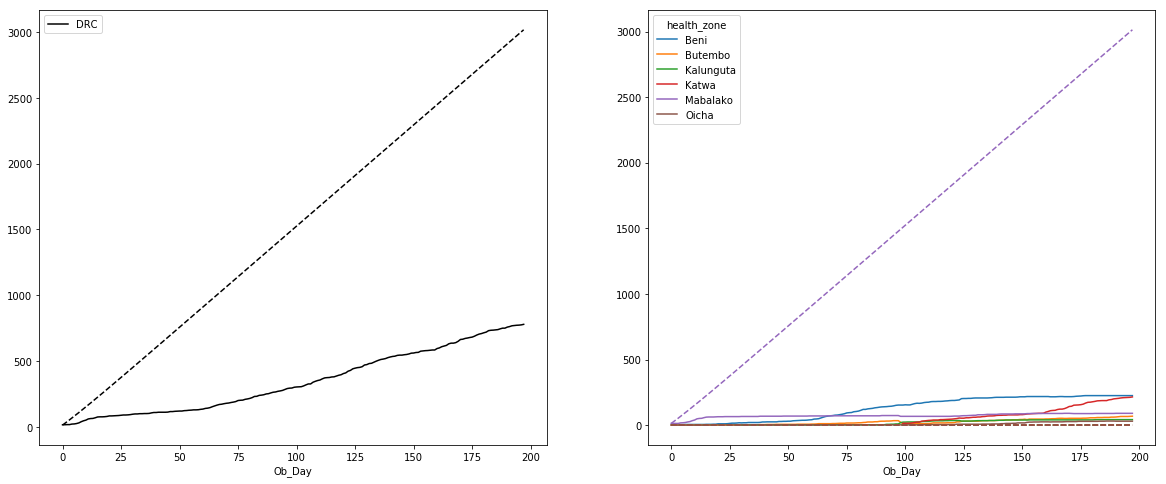

In [59]:
x_opt = [x_opt_dict[str(i)] for i in range(13)]
out_df = run_patchsim(x_opt)

f, axarr = plt.subplots(1,2, figsize=(20,8))
gt[gt.health_zone=='all'].plot(x='Ob_Day',y='total_c',ax=axarr[0],color='k',label='DRC')
out_df.sum().cumsum().plot(ax=axarr[0],color='k',ls='--')

gt[gt.health_zone.isin(key_hzs)].pivot(index='Ob_Day',columns='health_zone',values='total_c').plot(ax=axarr[1])
axarr[1].set_prop_cycle(None)
out_df.loc[[k.upper() for k in key_hzs]].T.cumsum().plot(ax=axarr[1],ls='--',legend=False)